In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from PIL import Image
import seaborn as sns

In [37]:
#load data
data_dir = 'All_Images'

In [39]:
# List all classes (types of rice)
classes = os.listdir(data_dir)
print(classes)

['Karacadag', '.DS_Store', 'Ipsala', 'Arborio', 'Basmati', 'Jasmine']


In [63]:
# List all subdirectories (classes) in the data directory
classes = [cls for cls in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, cls))]
print("Classes:", classes)

# Count the number of images in each class
class_counts = {}
for cls in classes:
    class_dir = os.path.join(data_dir, cls)
    class_counts[cls] = len([img for img in os.listdir(class_dir) if not img.startswith('.')])  # Ignore hidden files

print("Class counts:", class_counts)

Classes: ['Karacadag', 'Ipsala', 'Arborio', 'Basmati', 'Jasmine']
Class counts: {'Karacadag': 15000, 'Ipsala': 15000, 'Arborio': 15000, 'Basmati': 15000, 'Jasmine': 15000}


In [65]:
# Resize images to a common size (e.g., 128x128)
resized_images = [image.resize((128, 128)) for image in images]
resized_images = np.array(resized_images)

In [67]:
# Normalize pixel values to the range [0, 1]
normalized_images = resized_images / 255.0


In [69]:
# Convert labels to numerical format
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [115]:
X_train, X_test, y_train, y_test = train_test_split(normalized_images, encoded_labels, test_size=0.2, random_state=42)

In [117]:
#Data augmentation can help improve the generalization of your model 
#by creating additional training data through transformations like rotation, flipping, etc.

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the data generator on the training data
model=datagen.fit(X_train)

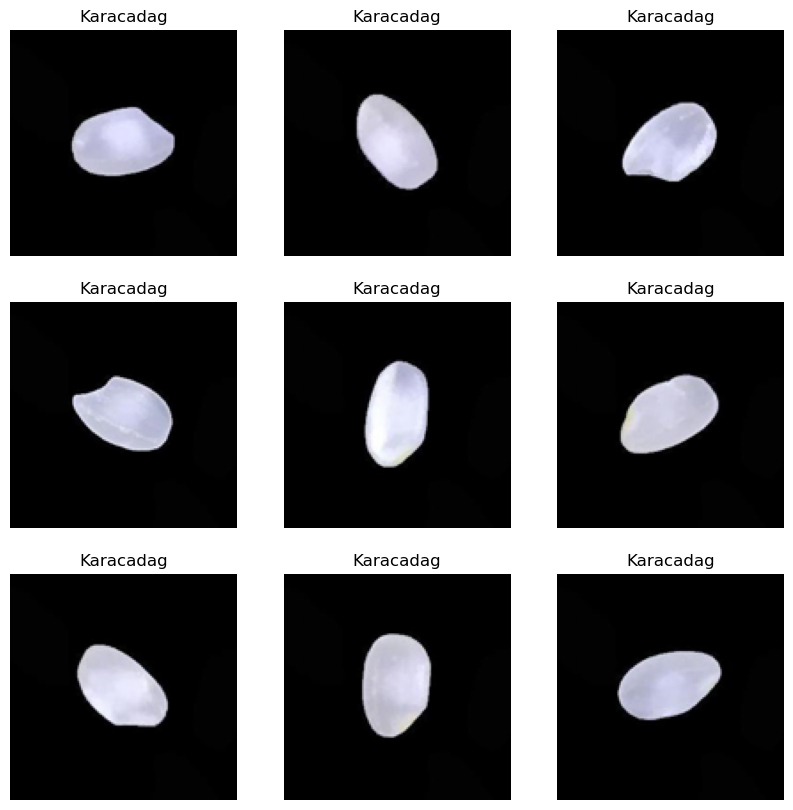

In [119]:
# Plot some images

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i])
    plt.title(label_encoder.inverse_transform([y_train[i]])[0])
    plt.axis('off')
plt.show()

In [121]:
# Save the preprocessed data
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

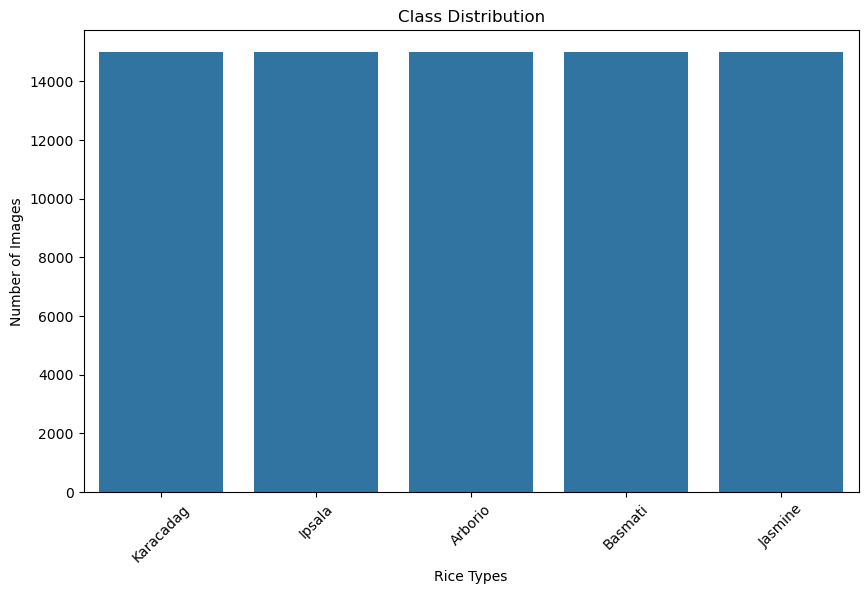

In [123]:
# Plot class distribution

plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Class Distribution")
plt.xlabel("Rice Types")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

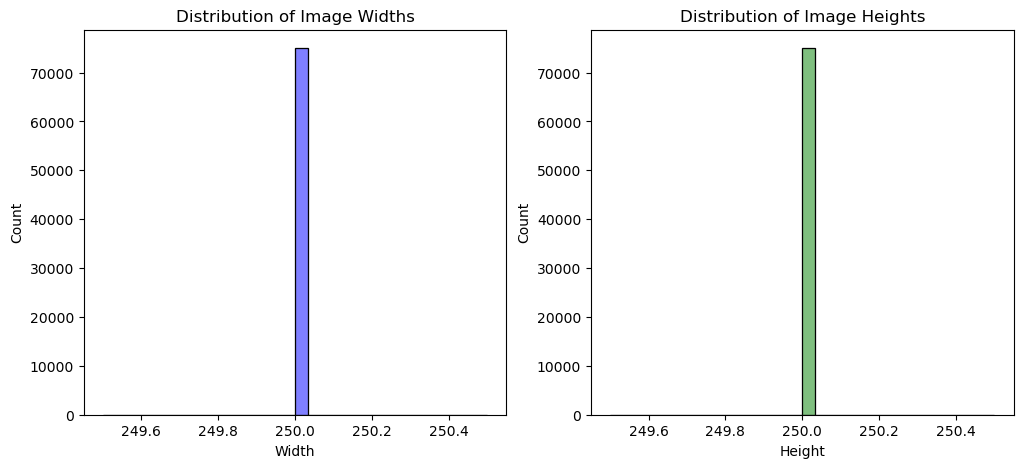

In [125]:
#Check the distribution of image sizes (width and height).
# Analyze image sizes

widths, heights = [], []
for cls in classes:
    class_dir = os.path.join(data_dir, cls)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        widths.append(img.size[0])
        heights.append(img.size[1])

# Plot image size distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(widths, bins=30, kde=True, color='blue')
plt.title("Distribution of Image Widths")
plt.xlabel("Width")

plt.subplot(1, 2, 2)
sns.histplot(heights, bins=30, kde=True, color='green')
plt.title("Distribution of Image Heights")
plt.xlabel("Height")
plt.show()

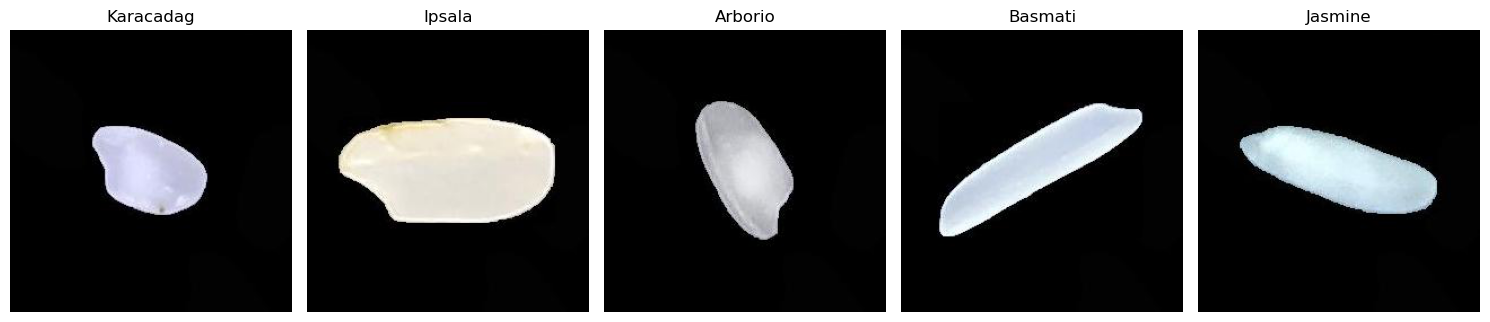

In [126]:
# Display sample images

fig, axes = plt.subplots(1, 5, figsize=(15, 4))  # 1 row, 5 columns for 5 samples
for i, cls in enumerate(classes):
    class_dir = os.path.join(data_dir, cls)
    img_names = [img for img in os.listdir(class_dir) if not img.startswith('.')]  # Ignore hidden files
    img_name = img_names[0]  # Take the first image from each class
    img_path = os.path.join(class_dir, img_name)
    img = Image.open(img_path)
    
    axes[i].imshow(img)
    axes[i].set_title(cls)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

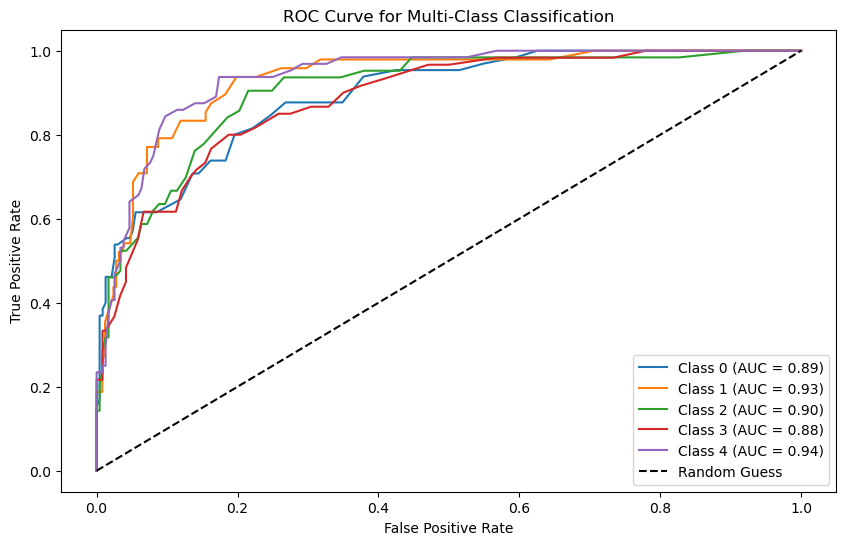

In [129]:

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Example: Generate a synthetic dataset
X, y = make_classification(n_samples=1000, n_classes=5, n_informative=10, n_features=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a model (example: RandomForestClassifier)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Generate predictions
y_pred = model.predict(X_test)  # Predicted class labels
y_pred_proba = model.predict_proba(X_test)  # Predicted probabilities for each class

# Binarize the labels
classes = np.unique(y_test)
y_true_bin = label_binarize(y_test, classes=classes)
y_pred_bin = label_binarize(y_pred, classes=classes)

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[cls], tpr[cls], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

# Plot ROC curves
plt.figure(figsize=(10, 6))
for cls in classes:
    plt.plot(fpr[cls], tpr[cls], label=f'Class {cls} (AUC = {roc_auc[cls]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Classification")
plt.legend()
plt.show()

In [157]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator with any desired data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0,1]
    validation_split=0.2  # Split the data into 80% training and 20% validation
)

# Use the flow_from_directory method to create training and validation generators
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),  # Resize images to 150x150
    batch_size=32,
    class_mode='categorical',
    subset='training',  # Set as training data
    seed=42
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation',  # Set as validation data
    seed=42
)

Found 60000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


In [165]:
# Define the ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale, no augmentation

# Use the flow_from_directory method to create a test generator
test_generator = test_datagen.flow_from_directory(
    data_dir,  # Path to the test dataset directory
    target_size=(150, 150),  # Resize images to 150x150
    batch_size=32,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=False  # Do not shuffle test data
)

Found 75000 images belonging to 5 classes.


In [167]:
#Create CNN
CNN= tf.keras.models.Sequential()

In [169]:

# First Convolutional Layer
CNN.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[150, 150, 3]))

# First Pooling Layer
CNN.add(MaxPooling2D(pool_size=2, strides=2))

# Second Convolutional Layer
CNN.add(Conv2D(filters=64, kernel_size=3, activation='relu'))

# Second Pooling Layer
CNN.add(MaxPooling2D(pool_size=2, strides=2))

# Third Convolutional Layer
CNN.add(Conv2D(filters=128, kernel_size=3, activation='relu'))

# Third Pooling Layer
CNN.add(MaxPooling2D(pool_size=2, strides=2))

# Flatten the layers
CNN.add(Flatten())

# Fully Connected Layer
CNN.add(Dense(units=128, activation='relu'))

# Output Layer
CNN.add(Dense(units=train_generator.num_classes, activation='softmax'))


In [171]:
# Compile the CNN
CNN.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
CNN.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,997 (18.42 MB)

 Trainable params: 4,828,997 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [173]:
training_test=CNN.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=5
)

Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 401s 213ms/step - accuracy: 0.9320 - loss: 0.1910 - val_accuracy: 0.9648 - val_loss: 0.1012
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 426s 227ms/step - accuracy: 0.9721 - loss: 0.0808 - val_accuracy: 0.9814 - val_loss: 0.0531
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 423s 226ms/step - accuracy: 0.9887 - loss: 0.0336 - val_accuracy: 0.9941 - val_loss: 0.0164
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 428s 228ms/step - accuracy: 0.9930 - loss: 0.0203 - val_accuracy: 0.9955 - val_loss: 0.0153
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 430s 229ms/step - accuracy: 0.9953 - loss: 0.0155 - val_accuracy: 0.9925 - val_loss: 0.0232


In [175]:
test_loss, test_accuracy = CNN.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

2344/2344 ━━━━━━━━━━━━━━━━━━━━ 151s 65ms/step - accuracy: 0.9949 - loss: 0.0152
Test Accuracy: 99.45%


In [177]:
CNN.save('my_model.keras')

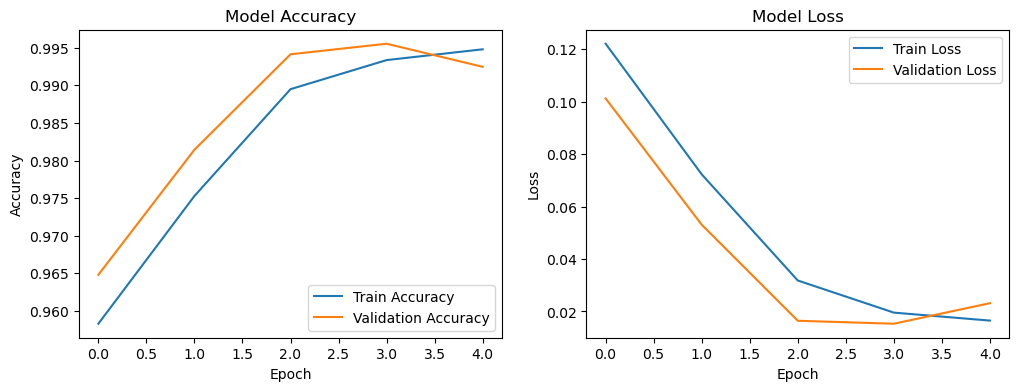

In [183]:
import matplotlib.pyplot as plt


# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_test.history['accuracy'], label='Train Accuracy')
plt.plot(training_test.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(training_test.history['loss'], label='Train Loss')
plt.plot(training_test.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()